# Compare the Encoding/Decoding Quality of Various EnCodeec Models

In [1]:
from datasets import load_dataset, Audio
from transformers import EncodecModel, AutoProcessor

# dummy dataset, however you can swap this with an dataset on the 🤗 hub or bring your own
librispeech_dummy = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

# load the model + processor (for pre-processing the audio)
model = EncodecModel.from_pretrained("facebook/encodec_24khz")
processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")

# cast the audio data to the correct sampling rate for the model
librispeech_dummy = librispeech_dummy.cast_column("audio", Audio(sampling_rate=processor.sampling_rate))
audio_sample = librispeech_dummy[0]["audio"]["array"]

# pre-process the inputs
inputs = processor(raw_audio=audio_sample, sampling_rate=processor.sampling_rate, return_tensors="pt")

# explicitly encode then decode the audio inputs
encoder_outputs = model.encode(inputs["input_values"], inputs["padding_mask"])
audio_values = model.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, inputs["padding_mask"])[0]

# or the equivalent with a forward pass
audio_values = model(inputs["input_values"], inputs["padding_mask"]).audio_values

# you can also extract the discrete codebook representation for LM tasks
# output: concatenated tensor of all the representations
audio_codes = model(inputs["input_values"], inputs["padding_mask"]).audio_codes


/Users/azeez/miniforge3/envs/dance2music/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/azeez/miniforge3/envs/dance2music/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [2]:
from encodec import EncodecModel
from encodec.utils import convert_audio

import torchaudio
import torch

# Instantiate a pretrained EnCodec model
model = EncodecModel.encodec_model_24khz()
# The number of codebooks used will be determined bythe bandwidth selected.
# E.g. for a bandwidth of 6kbps, `n_q = 8` codebooks are used.
# Supported bandwidths are 1.5kbps (n_q = 2), 3 kbps (n_q = 4), 6 kbps (n_q = 8) and 12 kbps (n_q =16) and 24kbps (n_q=32).
# For the 48 kHz model, only 3, 6, 12, and 24 kbps are supported. The number
# of codebooks for each is half that of the 24 kHz model as the frame rate is twice as much.
model.set_target_bandwidth(6.0)
print(model.sample_rate, model.channels)

# Load and pre-process the audio waveform
wav_raw, sr = torchaudio.load("/Users/azeez/Documents/pose_estimation/Learning2Dance/l2d_eval/michael/I_3/I_3.wav")
wav = convert_audio(wav_raw, sr, model.sample_rate, model.channels)
wav = wav.unsqueeze(0)

# Extract discrete codes from EnCodec
with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)  # [B, n_q, T]

/Users/azeez/miniforge3/envs/dance2music/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


24000 1


In [3]:
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio, display

display(Audio(wav_raw, rate=22050))

In [4]:
audio_values.shape
audio_sample.shape

(140520,)

In [5]:
print("Original:")
display(Audio(audio_sample, rate=22050))
print("Reconstructed:")
display(Audio(audio_values[0].detach().numpy(), rate=22050))

Original:


Reconstructed:


In [6]:
from datasets import load_dataset, Audio
from transformers import EncodecModel, AutoProcessor

test_path = "/Users/azeez/Documents/pose_estimation/MusicCaps/wavs/O28kY0aN8VI_30_40.wav"
audio_sample, sampling_rate = torchaudio.load(test_path)


# load the model + processor (for pre-processing the audio)
model = EncodecModel.from_pretrained("facebook/encodec_24khz")
processor = AutoProcessor.from_pretrained("facebook/encodec_24khz")

wav_raw, sr = torchaudio.load(test_path)
wav = convert_audio(wav_raw, sr, 24000, 1)
print(wav.shape)
wav = wav.unsqueeze(0)
print(wav.shape)

# pre-process the inputs
print(f"Processor sampling rate: {processor.sampling_rate}")
inputs = processor(raw_audio=wav[0][0], sampling_rate=processor.sampling_rate, return_tensors="pt")

# explicitly encode then decode the audio inputs
encoder_outputs = model.encode(inputs["input_values"], inputs["padding_mask"])
print(encoder_outputs.audio_scales)
print(type(encoder_outputs.audio_scales))
audio_values = model.decode(encoder_outputs.audio_codes, encoder_outputs.audio_scales, inputs["padding_mask"])[0]

# or the equivalent with a forward pass
audio_values = model(inputs["input_values"], inputs["padding_mask"]).audio_values


/Users/azeez/miniforge3/envs/dance2music/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


torch.Size([1, 240000])
torch.Size([1, 1, 240000])
Processor sampling rate: 24000
[None]
<class 'list'>


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.]]),
 array([   0.  ,   10.23,   20.46,   30.69,   40.92,   51.15,   61.38,
          71.61,   81.84,   92.07,  102.3 ,  112.53,  122.76,  132.99,
         143.22,  153.45,  163.68,  173.91,  184.14,  194.37,  204.6 ,
         214.83,  225.06,  235.29,  245.52,  255.75,  265.98,  276.21,
         286.44,  296.67,  306.9 ,  317.13,  327.36,  337.59,  347.82,
         358.05,  368.28,  378.51,  388.74,  398.97,  409.2 ,  419.43,
         429.66,  439.89,  450.12,  460.35,  470.58,  480.81,  491.04,
         501.27,  511.5 ,  521.73,  531.96,  542.19,  552.42,  562.65,
         572.88,  583.11,  593.34,  603.57,  613.8 ,  624.03,  634.26,
         644.49,  654.72,  664.95,  675.18,  685.41,  695.64,  705.87,
         716.1 ,  726.33,  736.56,  746.7

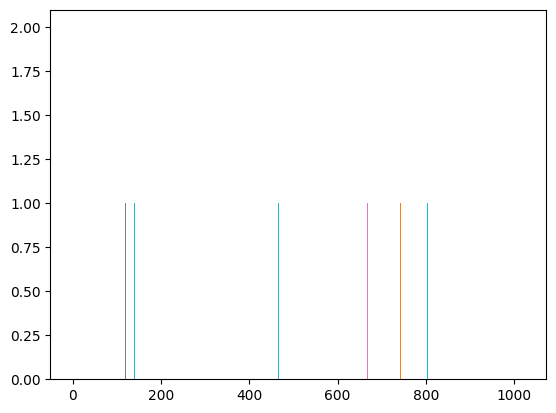

In [7]:
from matplotlib import pyplot as plt
plt.hist(encoder_outputs.audio_codes[0][0].detach().numpy(), bins=100)

In [8]:
from IPython.display import Audio, display

print("Original:")
print(type(wav), wav.shape)
display(Audio(wav[0], rate=22050))
print("Reconstructed:")
print(type(audio_values[0]), audio_values[0].shape)
display(Audio(audio_values[0].detach().numpy(), rate=22050))

Original:
<class 'torch.Tensor'> torch.Size([1, 1, 240000])


Reconstructed:
<class 'torch.Tensor'> torch.Size([1, 240000])
